### Install all dependencies

In [2]:
pip install pandas matplotlib statsmodels

### 2. Load and Preprocess the data

In [3]:
import pandas as pd

# Load your CSV file
df = pd.read_csv("/content/drive/MyDrive/485/Final/full_station_data.csv", parse_dates=["5 Minutes"])

# Filter for a specific station, ARIMA is a univariate time series model:it predicts the future of one variable based only on its own past
df = df[df["Station_ID"] == 715898]

# Set timestamp as index
df.set_index("5 Minutes", inplace=True)

# Create a total flow column (sum of 3 lanes)
df["Total_Flow"] = df["Lane 1 Flow (Veh/5 Minutes)"] + df["Lane 2 Flow (Veh/5 Minutes)"] + df["Lane 3 Flow (Veh/5 Minutes)"]

# Optionally downsample (e.g., to hourly):
# df = df.resample("H").sum()

### 3. Visualise the time series

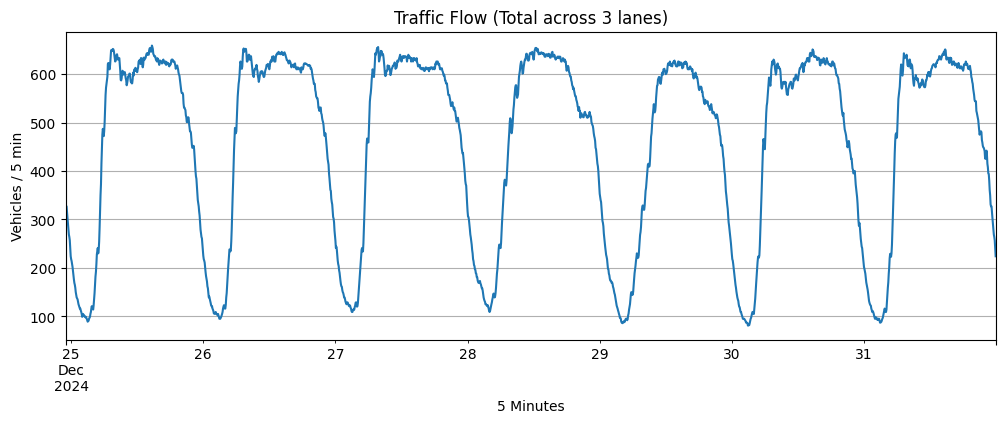

In [4]:
import matplotlib.pyplot as plt

df["Total_Flow"].plot(figsize=(12, 4), title="Traffic Flow (Total across 3 lanes)")
plt.ylabel("Vehicles / 5 min")
plt.grid(True)
plt.show()

### 4. Fit an ARIMA model

In [5]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model: order=(p,d,q) — try (1,1,1) initially
model = ARIMA(df["Total_Flow"], order=(1, 1, 1))
model_fit = model.fit()

# Summary
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Total_Flow   No. Observations:                 2028
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6479.137
Date:                Fri, 02 May 2025   AIC                          12964.275
Time:                        21:20:38   BIC                          12981.118
Sample:                    12-24-2024   HQIC                         12970.455
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7468      0.017     44.359      0.000       0.714       0.780
ma.L1         -0.0862      0.025     -3.444      0.001      -0.135      -0.037
sigma2        34.9737      0.884     39.582      0.0

### 5. Forcast future flow

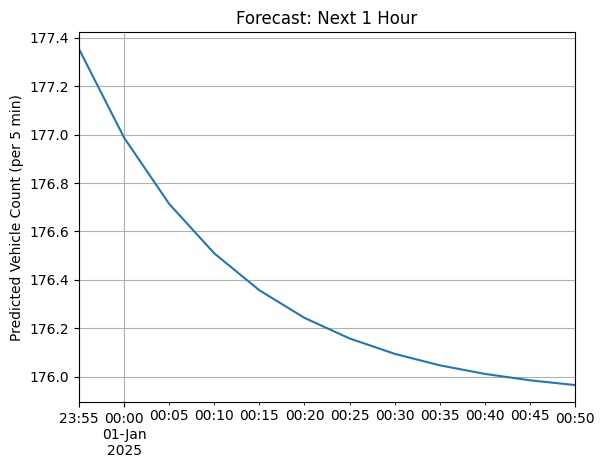

In [13]:
# Forecast next 12 intervals (12 x 5min = 1 hour)
forecast = model_fit.forecast(steps=12)

forecast = pd.Series(forecast, index=pd.date_range(start=df.index[-1], periods=12, freq='5min'))

# Plot forecast
forecast.plot(title="Forecast: Next 1 Hour")
plt.ylabel("Predicted Vehicle Count (per 5 min)")
plt.grid(True)
plt.show()

In [11]:
history = list(df["Total_Flow"])
preds = []

for _ in range(12):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    preds.append(yhat)
    history.append(yhat)

###################################################

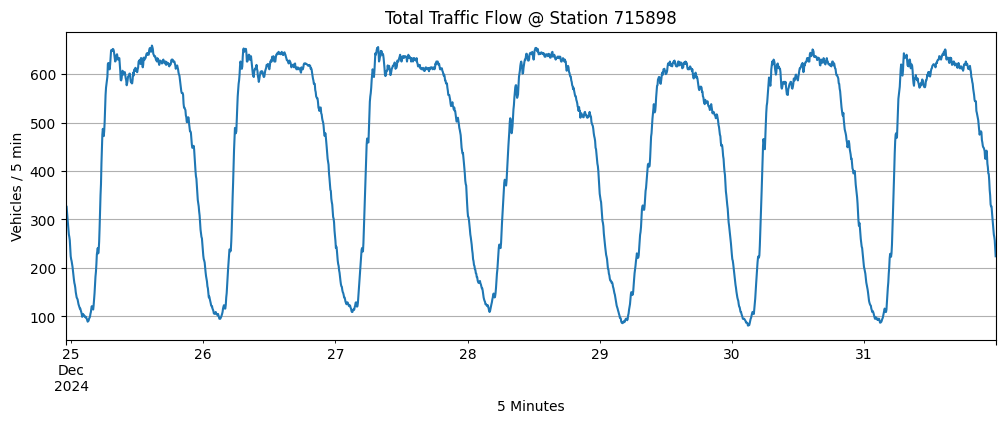

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/485/Final/full_station_data.csv", parse_dates=["5 Minutes"])
df.head()

# Filter for one station
station_id = 715898
df_station = df[df["Station_ID"] == station_id].copy()
df_station.set_index("5 Minutes", inplace=True)

# Combine lane flow (safely handling missing Lane 4)
df_station["Total_Flow"] = (
    df_station["Lane 1 Flow (Veh/5 Minutes)"].fillna(0) +
    df_station["Lane 2 Flow (Veh/5 Minutes)"].fillna(0) +
    df_station["Lane 3 Flow (Veh/5 Minutes)"].fillna(0) +
    df_station.get("Lane 4 Flow (Veh/5 Minutes)", pd.Series(0, index=df_station.index)).fillna(0)
)

# Plot the time series
df_station["Total_Flow"].plot(figsize=(12, 4), title=f"Total Traffic Flow @ Station {station_id}")
plt.ylabel("Vehicles / 5 min")
plt.grid(True)
plt.show()

In [18]:
# Fit ARIMA model
model = ARIMA(df_station["Total_Flow"], order=(1, 1, 1))
model_fit = model.fit()

# Print summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Total_Flow   No. Observations:                 2028
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6479.137
Date:                Fri, 02 May 2025   AIC                          12964.275
Time:                        21:45:57   BIC                          12981.118
Sample:                    12-24-2024   HQIC                         12970.455
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7468      0.017     44.359      0.000       0.714       0.780
ma.L1         -0.0862      0.025     -3.444      0.001      -0.135      -0.037
sigma2        34.9737      0.884     39.582      0.0

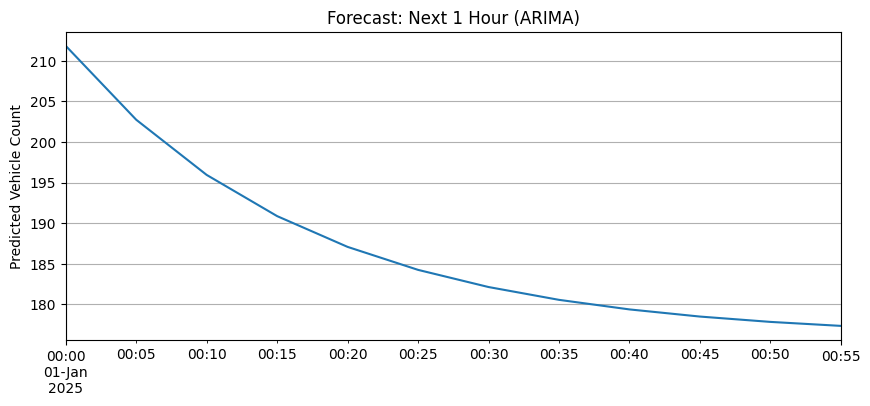

In [19]:
forecast = model_fit.forecast(steps=12)

# Plot forecast
forecast.plot(title="Forecast: Next 1 Hour (ARIMA)", figsize=(10, 4))
plt.ylabel("Predicted Vehicle Count")
plt.grid(True)
plt.show()

### Using SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_station["Total_Flow"], order=(1,1,1), seasonal_order=(1,1,1,288))
model_fit = model.fit()
forecast = model_fit.forecast(steps=1200)